## 서울시 따릉이 자전거 이용 예측 AI모델
각 날짜의 1시간 전의 기상상황을 활용 하여 따릉이 대여수를 예측해 보세요.
### 1. train.csv / test.csv
- id: 고유 id
- hour: 시간
- temperature: 기온
- precipitation: 비가 오지 않았으면 0, 비가 오면 1
- windspeed: 풍속(평균)
- humidity: 습도
- visibility: 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
- ozone: 오존
- pm10: 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- pm2.5: 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count: 시간에 따른 따릉이 대여 수


### 2.  submission.csv (제출 파일 형식)

### 3. 데이터 상세 설명
- 서울시 마포구의 날짜별, 시간별 기상상황과 따릉이 대여 수 데이터

#### `1.` 라이브러리 임포트

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import lightgbm as lgb                             # 회귀 모델 ⑤
from sklearn.linear_model import LinearRegression  # 선형 회귀 모델 ①
from sklearn.model_selection import KFold          # 모델의 교차검증을 위해 임포트합니다.
from sklearn.metrics import r2_score               # 모델의 평가지표입니다.
from sklearn.preprocessing import MinMaxScaler     # 0 ~ 1사이의 값으로 변환시켜주는 스케일러입니다.
from sklearn.linear_model import ElasticNet        # 선형 회귀 모델 ②
from sklearn.model_selection import GridSearchCV   # 최적의 파라미터를 찾기 위한 함수입니다.
from sklearn.ensemble import RandomForestRegressor # 회귀 모델 ④
from xgboost import XGBRegressor                   # 회귀 모델 ③

C:\Users\jinwa\anaconda3\envs\deep_learning_practice\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### `2.` 데이터 로드

In [2]:
train_data = pd.read_csv('./따릉이/train.csv')
test_data = pd.read_csv('./따릉이/test.csv')
submission_data = pd.read_csv('./따릉이/submission.csv')

#### `3-1.` 데이터 정보 확인 (train_data)

In [3]:
display(train_data)
print(train_data.info())
display(train_data.describe())

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...,...
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB
None


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


#### `3-2.` 데이터 정보 확인 (test_data)

In [4]:
display(test_data)
print(test_data.info())

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0
...,...,...,...,...,...,...,...,...,...,...
710,2148,1,24.6,0.0,2.4,60.0,1745.0,NaN,NaN,NaN
711,2149,1,18.1,0.0,1.0,55.0,2000.0,NaN,NaN,NaN
712,2165,9,23.3,0.0,2.3,66.0,1789.0,0.020,17.0,15.0
713,2166,16,27.0,0.0,1.6,46.0,1956.0,0.032,40.0,26.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB
None


#### `3-3.` 데이터 정보 확인 (submission_data)

In [5]:
display(submission_data)
print(submission_data.info())

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN
...,...,...
710,2148,NaN
711,2149,NaN
712,2165,NaN
713,2166,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      715 non-null    int64  
 1   count   0 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 11.3 KB
None


#### `4.` 데이터 전처리: 컬럼명 변경

In [6]:
# 데이터 설명과 상이하여 보기쉽게 컬럼명을 변경하겠습니다.
train_data.rename(columns={'hour_bef_temperature':'temperature', 'hour_bef_precipitation':'precipitation',
                           'hour_bef_windspeed':'windspeed', 'hour_bef_humidity':'humidity', 
                           'hour_bef_visibility':'visibility', 'hour_bef_ozone':'ozone', 'hour_bef_pm10':'pm10',
                           'hour_bef_pm2.5':'pm2.5'}, inplace=True)

test_data.rename(columns={'hour_bef_temperature':'temperature', 'hour_bef_precipitation':'precipitation',
                          'hour_bef_windspeed':'windspeed', 'hour_bef_humidity':'humidity', 
                          'hour_bef_visibility':'visibility', 'hour_bef_ozone':'ozone', 'hour_bef_pm10':'pm10',
                          'hour_bef_pm2.5':'pm2.5'}, inplace=True)

# 컬럼명 변경 후 데이터를 확인합니다.
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1459 non-null   int64  
 1   hour           1459 non-null   int64  
 2   temperature    1457 non-null   float64
 3   precipitation  1457 non-null   float64
 4   windspeed      1450 non-null   float64
 5   humidity       1457 non-null   float64
 6   visibility     1457 non-null   float64
 7   ozone          1383 non-null   float64
 8   pm10           1369 non-null   float64
 9   pm2.5          1342 non-null   float64
 10  count          1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             715 non-null    int64  
 1   hour           715 non

#### `5.` 데이터 전처리: 상관관계 확인

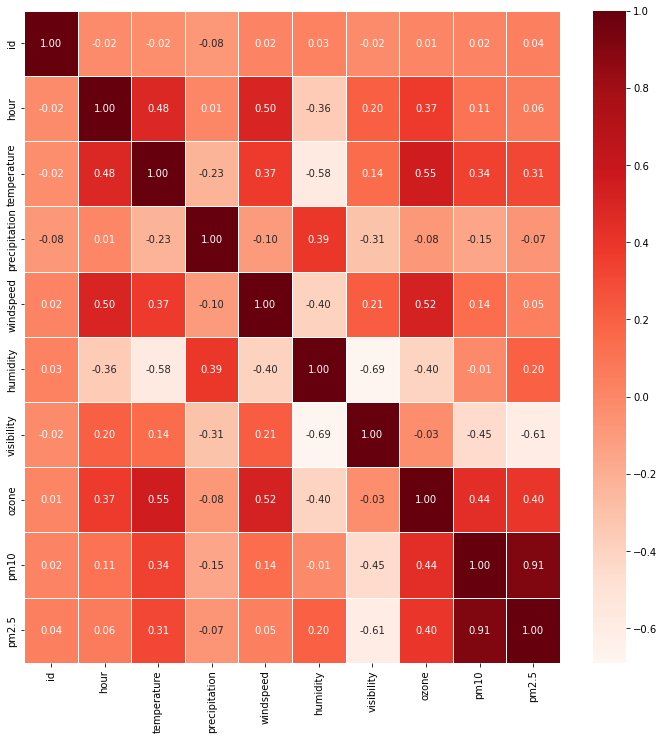

In [7]:
# 히트맵으로 각 데이터별 상관관계를 시각화합니다.
plt.figure(figsize=(12,12))              # plt.figure(figsize=(15,15)): 15x15의 크기로 그림을 그려달라는 것입니다.
sns.heatmap(data=test_data.corr(),       # data=: 시각화에 사용할 자료를 선택합니다.
            annot=True,                  # annot=: 셀 안에 숫자 표시 여부를 지정합니다.
            fmt='.2f',                   # fmt=: annot=True인 경우 숫자의 표시 형식을 지정합니다.
            linewidths=.5,               # linewidths=: 각 셀을 나눌 선의 두께를 지정합니다. 
            cmap='Reds')                 # cmap=: 표의 섹상을 지정합니다.

plt.show()

#### `6.` 데이터 전처리: 드랍

In [8]:
# target과 feature의 영향이 적은 id 컬럼은 드랍하겠습니다.
train_data.drop(columns=['id'], inplace=True)
test_data.drop(columns=['id'], inplace=True)

#### `7.` 데이터 전처리: 결측값 확인 및 치환 함수 생성

In [9]:
# 결측값을 확인합니다.
print('-----train_data 결측값-----')
print(train_data.isna().sum())
print('-----test_data 결측값-----')
print(test_data.isna().sum())

# 특정 조건에 따라 결측값이 있는 컬럼의 평균으로 치환하는 함수입니다.
def MissingValueAverageReplacement(data, re_column, con_column) :
    ref_value = data[data[re_column].isna() == 1] # 치환할 컬럼의 결측값이 있는 행의 인덱스 번호를 반환합니다.
    unique_value = ref_value[con_column].unique() # 조건 컬럼의 고유값을 반환합니다.
    re_col_idx = ref_value.index                  # 결측값을 치환할 컬럼의 인덱스 넘버를 반환합니다.
    
    i = 0                                                     # 슬라이싱에 사용될 변수 i를 0으로 초기화합니다.
    while True :                                              # break로 나올때까지 반복문을 돌립니다.
        idx = data[data[con_column] == unique_value[i]].index # 조건 컬럼에서 고유값의 i번째와 원소가 같은 인덱스 넘버를 반환합니다.
        new_data = data.iloc[idx]                             # 위에서 반환된 인덱스넘버로 새로운 데이터프레임을 만듭니다.
        ave_value = new_data[re_column].mean()                # 치환할 평균값을 반환합니다.
        data[re_column].iloc[idx] = (ave_value)               # 결측값 위치를 행 인덱스로 찾고 결측값을 평균값으로 치환합니다.
        i += 1                                                # 슬라이싱에 사용될 변수 i를 +1 합니다.
        if i >= len(unique_value) :                           # 만약 슬라이싱 변수 i가 고유값 a의 길이보다 크거나 같다면
            break                                             # 반복문을 종료합니다.

-----train_data 결측값-----
hour               0
temperature        2
precipitation      2
windspeed          9
humidity           2
visibility         2
ozone             76
pm10              90
pm2.5            117
count              0
dtype: int64
-----test_data 결측값-----
hour              0
temperature       1
precipitation     1
windspeed         1
humidity          1
visibility        1
ozone            35
pm10             37
pm2.5            36
dtype: int64


#### `8.` 데이터 전처리: 결측값 치환

In [10]:
# 결측값 개수가 적고 id 컬럼을 제외한 모든 컬럼이 target과의 상관관계가 높으므로 각 컬럼별 상관관계를 기준으로 평균을 
# 구한 뒤 결측값을 처리하여 사용하겠습니다. 먼저 학습 데이터를 치환합니다.
MissingValueAverageReplacement(train_data, 'windspeed', 'hour') # 결측값 처리 컬럼: 'windspeed' │ 조건 컬럼: 'hour'
MissingValueAverageReplacement(train_data, 'temperature', 'hour') # 결측값 처리 컬럼: 'temperature' │ 조건 컬럼: 'hour'
MissingValueAverageReplacement(train_data, 'humidity', 'temperature') # 결측값 처리 컬럼: 'humidity' │ 조건 컬럼: 'temperature'
MissingValueAverageReplacement(train_data, 'precipitation', 'humidity') # 결측값 처리 컬럼: 'precipitation' │ 조건 컬럼: 'humidity'
MissingValueAverageReplacement(train_data, 'pm10', 'humidity') # 결측값 처리 컬럼: 'pm10' │ 조건 컬럼: 'humidity'
MissingValueAverageReplacement(train_data, 'ozone', 'windspeed') # 결측값 처리 컬럼: 'ozone' │ 조건 컬럼: 'windspeed'
MissingValueAverageReplacement(train_data, 'visibility', 'humidity') # 결측값 처리 컬럼: 'visibility' │ 조건 컬럼: 'humidity.5'
MissingValueAverageReplacement(train_data, 'ozone', 'humidity') # 결측값 처리 컬럼: 'ozone' │ 조건 컬럼: 'temperahumidityture'
MissingValueAverageReplacement(train_data, 'pm2.5', 'humidity') # 결측값 처리 컬럼: 'pm2.5' │ 조건 컬럼: 'temperahumidityture'

# 테스트 데이터를 치환합니다.
MissingValueAverageReplacement(test_data, 'windspeed', 'hour') # 결측값 처리 컬럼: 'windspeed' │ 조건 컬럼: 'hour'
MissingValueAverageReplacement(test_data, 'ozone', 'windspeed') # 결측값 처리 컬럼: 'temperature' │ 조건 컬럼: 'hour'
MissingValueAverageReplacement(test_data, 'temperature', 'ozone') # 결측값 처리 컬럼: 'temperature' │ 조건 컬럼: 'ozone'
MissingValueAverageReplacement(test_data, 'humidity', 'temperature') # 결측값 처리 컬럼: 'humidity' │ 조건 컬럼: 'temperature'
MissingValueAverageReplacement(test_data, 'visibility', 'humidity') # 결측값 처리 컬럼: 'visibility' │ 조건 컬럼: 'humidity'
MissingValueAverageReplacement(test_data, 'precipitation', 'humidity') # 결측값 처리 컬럼: 'precipitation' │ 조건 컬럼: 'humidity'
MissingValueAverageReplacement(test_data, 'pm10', 'ozone') # 결측값 처리 컬럼: 'pm10' │ 조건 컬럼: 'ozone'
MissingValueAverageReplacement(test_data, 'pm2.5', 'pm10') # 결측값 처리 컬럼: 'pm2.5' │ 조건 컬럼: 'pm10'

# 치환 한 뒤 결측값을 확인합니다.
print('-----train_data 결측값-----')
print(train_data.isna().sum())
print('-----test_data 결측값-----')
print(test_data.isna().sum())

C:\Users\jinwa\AppData\Local\Temp/ipykernel_6288/3118407888.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[re_column].iloc[idx] = (ave_value)               # 결측값 위치를 행 인덱스로 찾고 결측값을 평균값으로 치환합니다.


-----train_data 결측값-----
hour             0
temperature      0
precipitation    0
windspeed        0
humidity         0
visibility       0
ozone            0
pm10             0
pm2.5            0
count            0
dtype: int64
-----test_data 결측값-----
hour             0
temperature      0
precipitation    0
windspeed        0
humidity         0
visibility       0
ozone            0
pm10             0
pm2.5            0
dtype: int64


#### `9-1.` 데이터 전처리: 이상치 확인

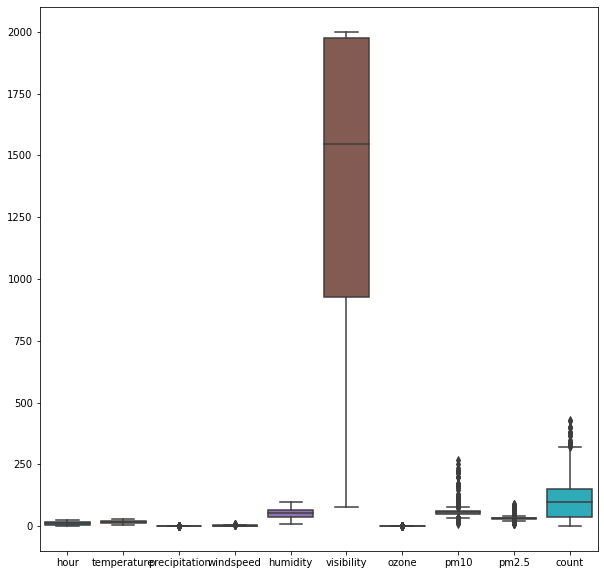

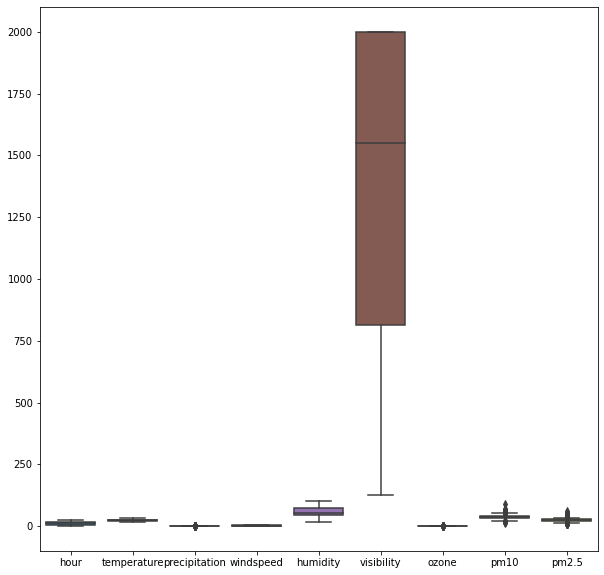

In [11]:
# 학습과 테스트 데이터의 이상치를 시각화하여 확인합니다.
plt.figure(figsize=(10, 10))
sns.boxplot(data=train_data)
plt.figure(figsize=(10, 10))
sns.boxplot(data=test_data)
plt.show()

#### `9-2.` 데이터 전처리: 이상치 제거

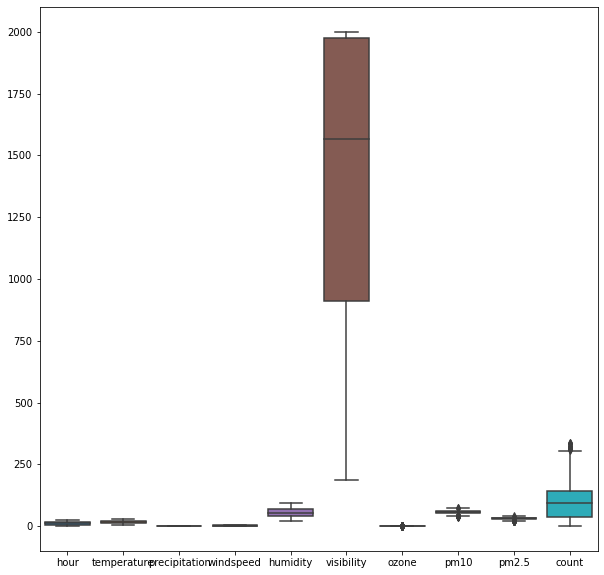

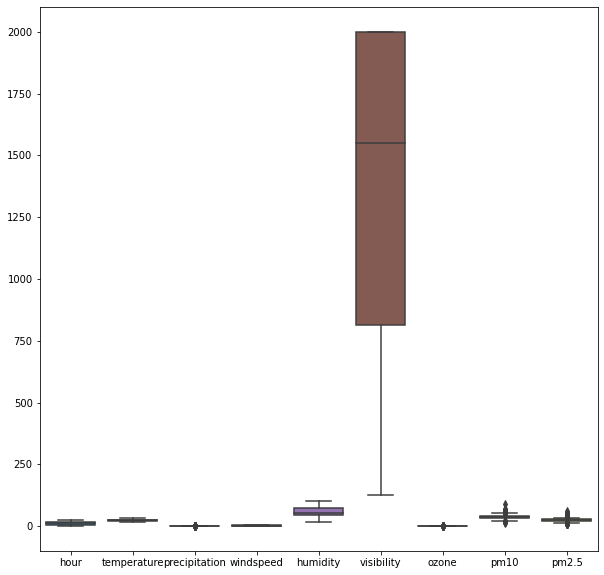

In [12]:
# 이상치를 제거하는 함수입니다.
def get_outlier(df=None, column=None, weight=1.5):
    
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

# 타겟값의 상관계수가 높은 컬럼순으로 함수를 사용하여 반환된 인덱스 번호로 이상치를 제거합니다.
for i in ['ozone', 'humidity', 'windspeed', 'precipitation', 'pm2.5', 'pm10'] :
    outlier_idx = get_outlier(df=train_data, column=i, weight=1.5)
    train_data.drop(outlier_idx, axis=0, inplace=True)

# 이상치 제거 후 학습과 테스트 데이터를 시각화 합니다.
plt.figure(figsize=(10, 10))
sns.boxplot(data=train_data)
plt.figure(figsize=(10, 10))
sns.boxplot(data=test_data)
plt.show()

#### `10.` 데이터 전처리: 피쳐와 타겟 분리

In [13]:
# 피쳐로 사용할 데이터는 타겟값을 드랍한 나머지 특성을 전달합니다.
feature_train = train_data.copy().drop(['count'], axis=1)
feature_test = test_data.copy()

# 타겟으로 사용할 원본 데이터의 count 컬럼을 넘겨줍니다.
target = np.log1p(train_data['count'])

# 데이터를 확인합니다.
display(feature_train)
display(feature_test)
display(target)

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5
1,13,20.1,0.0,3.281356,48.0,916.0,0.037944,60.608696,31.652174
2,6,13.9,0.0,0.700000,79.0,1382.0,0.032312,42.583333,25.272727
6,3,10.6,0.0,1.620000,58.0,1548.0,0.028421,55.157895,29.736842
8,9,13.8,0.0,1.900000,64.0,1344.0,0.033053,52.687500,28.625000
10,4,5.7,0.0,0.600000,77.0,1960.0,0.029000,52.500000,31.083333
...,...,...,...,...,...,...,...,...,...
1450,15,23.1,0.0,4.300000,23.0,1798.0,0.052928,55.000000,20.909091
1451,3,18.1,0.0,1.620000,77.0,272.0,0.029000,52.500000,31.083333
1454,4,16.8,0.0,1.600000,53.0,2000.0,0.033894,67.416667,33.166667
1457,21,20.7,0.0,3.700000,37.0,1395.0,0.054250,71.000000,36.000000


,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5
0,7,20.7,0.0,1.3,62.0,954.0,0.041000,44.000000,31.500000
1,17,30.0,0.0,5.4,33.0,1590.0,0.061000,49.000000,36.000000
2,13,19.0,1.0,2.1,95.0,193.0,0.020000,36.000000,28.000000
3,6,22.5,0.0,2.5,60.0,1185.0,0.042929,34.857143,23.071429
4,22,14.6,1.0,3.4,93.0,218.0,0.041000,18.000000,15.000000
...,...,...,...,...,...,...,...,...,...
710,1,24.6,0.0,2.4,60.0,1745.0,0.041185,33.370370,24.074074
711,1,18.1,0.0,1.0,55.0,2000.0,0.023769,33.153846,22.923077
712,9,23.3,0.0,2.3,66.0,1789.0,0.020000,17.000000,15.000000
713,16,27.0,0.0,1.6,46.0,1956.0,0.035316,29.157895,21.157895


1       5.075174
2       3.295837
6       3.178054
8       3.688879
10      1.945910
          ...   
1450    5.587249
1451    3.295837
1454    3.091042
1457    5.379897
1458    5.141664
Name: count, Length: 946, dtype: float64

#### `11.` 데이터 전처리: 스케일링

In [14]:
# 표준화를 위해 스케일러 모델을 scaler 변수에 할당하여 객체를 생성하겠습니다.
scaler = MinMaxScaler()

scaler.fit(feature_train)

# 스케일링을 진행합니다.
feature_train_scaled = scaler.transform(feature_train)
feature_test_scaled = scaler.transform(feature_test)

# 스케일링 후 데이터의 크기를 확인합니다.
print('feature_train_scaled.shape', feature_train_scaled.shape)
print('feature_test_scaled.shape', feature_test_scaled.shape)

# 스케일링 된 데이터를 테이터프레임으로 전환합니다.
feature_train_scaled = pd.DataFrame(feature_train_scaled)
feature_test_scaled = pd.DataFrame(feature_test_scaled)

feature_train_scaled.shape (946, 9)
feature_test_scaled.shape (715, 9)


#### `11-1.` 모델 구축 및 교차 검증 평가 (LinearRegression)

In [15]:
# 구하고자 하는 타깃 값은 대여 수로 이는 연속된 값을 구하는 것입니다. 따라서 예측에 유리한 회귀 모델을 사용하겠습니다.
# 과적합(Overfitting)을 방지하기 위해 K-Fold 함수를 사용하여 교차 검증을 실시하겠습니다.

# LinearRegression 모델 함수를 lr_model 변수에 할당합니다.
lr_model = LinearRegression()

# K-Fold로 교차 검증을 위한 데이터를 나눕니다.
lr_k_fold = KFold(n_splits=5,      # n_splits=: 교차 검증을 몇 번 할 것인가 즉 데이터를 몇 등분할 것인가를 정합니다.
                   shuffle=True,    # shuffle=: 데이터를 섞을지 지정합니다.
                   random_state=23) # random_state=: seed값을 지정합니다.

lr_model_score = [] # K-Fold로 나누어진 데이터의 각 세트별 R2 값을 저장할 리스트 변수입니다.

# K-Fold 객체에 split() 함수를 호출하면 폴드별 학습과 테스트 데이터의 행 인덱스를 배열로 반환합니다.
for train_idx, test_idx in lr_k_fold.split(feature_train_scaled) :
    x_train, x_test = feature_train_scaled.iloc[train_idx], feature_train_scaled.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    # 나누어진 데이터로 모델 학습과 예측을 진행합니다.
    lr_model.fit(x_train, y_train)
    
    # 모델의 예측을 진행합니다.
    model_pred = lr_model.predict(x_test)
    
    # r2를 측정 한 후 리스트에 더해 나갑니다.
    lr_model_score.append(np.round(r2_score(y_test, model_pred), 4))

# 개별 세트별로 측정한 정확도를 합하여 평균 정확도를 계산합니다.
print('r2_score: ', np.mean(lr_model_score))

r2_score:  0.58988


#### `11-2.` 모델 구축 및 교차 검증 평가 (ElasticNet)

In [16]:
en_model = ElasticNet(alpha=0.001, l1_ratio=0.2, max_iter=1000, random_state=23)

en_k_fold = KFold(n_splits=5, shuffle=True, random_state=23) 

en_model_score = [] 

for train_idx, test_idx in en_k_fold.split(feature_train_scaled) :
    x_train, x_test = feature_train_scaled.iloc[train_idx], feature_train_scaled.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    en_model.fit(x_train, y_train)
    
    model_pred = en_model.predict(x_test)
        
    en_model_score.append(np.round(r2_score(y_test, model_pred), 4))

print('r2_score: ', np.mean(en_model_score))

r2_score:  0.59012


#### `11-2.` 모델 구축 및 교차 검증 평가 (RandomForestRegressor)

In [17]:
rfr_model = RandomForestRegressor(n_estimators=300, max_depth=6, random_state=23)

rfr_k_fold = KFold(n_splits=5, shuffle=True, random_state=23) 

rfr_model_score = [] 

for train_idx, test_idx in rfr_k_fold.split(feature_train_scaled) :
    x_train, x_test = feature_train_scaled.iloc[train_idx], feature_train_scaled.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    rfr_model.fit(x_train, y_train)
    
    model_pred = rfr_model.predict(x_test)
        
    rfr_model_score.append(np.round(r2_score(y_test, model_pred), 4))

print('r2_score: ', np.mean(rfr_model_score))

r2_score:  0.7712


#### `11-3.` 모델 구축 및 교차 검증 평가 (RandomForestRegressor)

In [18]:
xgb_model = XGBRegressor(n_estimators=250, max_depth=4, learning_rate=0.03, random_state=23)

xgb_k_fold = KFold(n_splits=5, shuffle=True, random_state=23) 

xgb_model_score = [] 

for train_idx, test_idx in xgb_k_fold.split(feature_train_scaled) :
    x_train, x_test = feature_train_scaled.iloc[train_idx], feature_train_scaled.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    xgb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=100, verbose=0)
    
    model_pred = xgb_model.predict(x_test)
        
    xgb_model_score.append(np.round(r2_score(y_test, model_pred), 4))

print('r2_score: ', np.mean(xgb_model_score))

C:\Users\jinwa\anaconda3\envs\deep_learning_practice\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\jinwa\anaconda3\envs\deep_learning_practice\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\jinwa\anaconda3\envs\deep_learning_practice\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\jinwa\anaconda3\envs\deep_learning_practice\lib\site-packages

r2_score:  0.7722199999999999


#### `11-4.` 모델 구축 및 교차 검증 평가 (LGBMRegressor)

In [19]:
lgb_model = lgb.LGBMRegressor(max_depth=5, learning_rate=0.01, n_estimators=400, min_child_samples=30, 
                              random_state=23)

lgb_k_fold = KFold(n_splits=5, shuffle=True, random_state=23)

lgb_score = []

for train_idx, test_idx in lgb_k_fold.split(feature_train_scaled) :
    x_train, x_test = feature_train_scaled.iloc[train_idx], feature_train_scaled.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
 
    lgb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=100, verbose=0)
    
    model_pred = lgb_model.predict(x_test)
    
    lgb_score.append(np.round(r2_score(y_test, model_pred), 4))

print('r2_score: ', np.mean(lgb_score))

C:\Users\jinwa\anaconda3\envs\deep_learning_practice\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jinwa\anaconda3\envs\deep_learning_practice\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jinwa\anaconda3\envs\deep_learning_practice\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callbac

r2_score:  0.77696


1. LinearRegression
- 결측값 제거, 이상치 제거 x, 스케일링 x: 0.5689
- 결측값 제거, 이상치 제거 o, 스케일링 x: 0.5847
- 결측값 제거, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 x: 0.5847
- 결측값 제거, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 o: 0.5888
- 결측값 치환, 이상치 제거 x, 스케일링 x: 0.5691 (+0.0002)
- 결측값 치환, 이상치 제거 o, 스케일링 x: 0.5878 (+0.0031)
- 결측값 치환, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 x: 0.5867 (+0.0020)
- 결측값 치환, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 o: 0.5898 (+0.0010)
2. ElasticNet
- 결측값 제거, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 o: 0.5861
- 결측값 치환, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 o: 0.5901 (+0.0040)
3. RandomForestRegressor
- 결측값 제거, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 o: 0.7643
- 결측값 치환, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 o: 0.7712 (+0.0069)
4. RandomForestRegressor
- 결측값 제거, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 o: 0.7693
- 결측값 치환, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 o: 0.7722 (+0.0029)
5. LGBMRegressor
- 결측값 제거, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 o: 0.7713
- 결측값 치환, 이상치 제거 o, 피처 스케일링 o, 타겟 로그 변환 o: 0.7796 (+0.0083)

In [20]:
# # 그리드 서치로 최적의 파라미터를 찾습니다.
# params = {'max_depth':[3, 4, 5, 6, 7, 8, 9], 'learning_rate':[0.01, 0.003, 0.001, 0.0003, 0.0001], 
#           'n_estimators':[100, 200, 300, 400, 500], 'min_child_samples':[20, 30, 40, 50, 60, 70, 80]}

# def FindTheBestParameters(model, params, k_fold) :
#     # estimator: 적용할 모델 등을 지정합니다.
#     # param_grid: 튜닝을 위해 파라미터를 지정합니다. 리스트 형식으로 변수에 할당해서 사용합니다.
#     # scoring: 예측 성능을 측정할 평가 방법을 지정합니다. 보통 accuracy 로 지정하여서 정확도로 성능 평가를 합니다. 
#     # cv: 교차 검증에서 몇개로 분할되는지 지정합니다.
#     gr_se = GridSearchCV(estimator=model, 
#                          param_grid = params,
#                          scoring = 'neg_mean_squared_error',
#                          cv=k_fold)

#     # 학습합니다.
#     gr_se.fit(feature_train_scaled, target)

#     # 최적의 파라미터를 출력합니다.
#     print(gr_se.best_params_)

# FindTheBestParameters(lgb_model, params, lgb_k_fold)

In [25]:
lgb_pred = [0 if x <0 else x for x in lgb_model.predict(feature_test_scaled)]
submission_data['count'] = lgb_pred
submission_data.to_csv('submission_data.csv', index=False)